# Laporan Kelompok 7 - Word Cloud

Dataset : [Dataset](http://bit.ly/2ZujQaD)

*   Aditya Raybol Saragih
*   Yanuar Pratama Pandjaitan
*   Lutfi Rizky Ramadhan



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS

import time

Using TensorFlow backend.


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset = "/content/drive/My Drive/DTSAI/Word/Sentiment/data_latih.json"
datajson = pd.read_json(dataset)

In [0]:
keynorm = "/content/drive/My Drive/DTSAI/Word/Sentiment/key_norm.csv"
key_norm = pd.read_csv(keynorm)

In [6]:
key_norm.head()

,_id,singkat,hasil
0,1,abis,habis
1,2,accent,tekanan
2,3,accept,terima
3,4,accident,kecelakaan
4,5,achievement,prestasi


In [7]:
datajson.head()

,akun,id_user,isi,sentimen,tanggal
0,@AhokDjarot,823082326213021696,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral,Tue Apr 04 14:04:05 +0000 2017
1,@AhokDjarot,3166296157,@AhokDjarot Melayani warga jakarta mulai dari ...,positif,Tue Apr 04 14:00:01 +0000 2017
2,@AhokDjarot,799108167170949121,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif,Tue Apr 04 13:56:37 +0000 2017
3,@AhokDjarot,710566116553166849,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,positif,Tue Apr 04 13:52:44 +0000 2017
4,@AhokDjarot,1335669534,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,positif,Tue Apr 04 13:50:01 +0000 2017


In [8]:
datajson.isnull().values.any()

False

In [9]:
data = datajson[['isi','sentimen']]
data.head()

,isi,sentimen
0,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral
1,@AhokDjarot Melayani warga jakarta mulai dari ...,positif
2,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif
3,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,positif
4,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,positif


In [10]:
len(data)

650

## 1 - Data Pre-Processing

*   Menghilangkan Stopwords



In [0]:
sw = set(stopwords.words("indonesian"))
sw.add(("amp"))
data['isi'] = data['isi'].apply(lambda x: x.lower())
data['isi'] = data['isi'].apply((lambda x: 
                                 [word for word in x.split()
                                 if 'http' not in word
                                  and not word.startswith('@')
                                  and not word.startswith('#')
                                  and word != 'rt'
                                  ]))
data['isi'] = data['isi'].apply((lambda x: [word for word in x if not word in sw]))
data['isi'] = data['isi'].apply((lambda x: " ".join(x)))

*   Menghapus tanda baca



In [0]:
data['isi'] = data['isi'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [13]:
data.head()

,isi,sentimen
0,penasaran yg dijawab dgn terpilih ak,netral
1,melayani warga jakarta lahir program,positif
2,golongan sumbu pendek lo fpi piaraan kluarga c...,negatif
3,ahok didzolimi ahok bebas,positif
4,prof edward omar sharif h ahli pidana pndpt a...,positif


In [0]:
positif = data[data['sentimen'] == 'positif']
netral = data[data['sentimen'] == 'netral']
negatif = data[data['sentimen'] == 'negatif']

In [15]:
positif.head()

,isi,sentimen
1,melayani warga jakarta lahir program,positif
3,ahok didzolimi ahok bebas,positif
4,prof edward omar sharif h ahli pidana pndpt a...,positif
5,ahok didzolimi ahok bebas,positif
6,ahok djarot kece badai menata kota jakarta,positif


In [16]:
len(positif)

291

In [17]:
netral.head()

,isi,sentimen
0,penasaran yg dijawab dgn terpilih ak,netral
7,penasaran yg dijawab dgn terpilih ak,netral
74,warga diluar dki berharap pilkada dki pu,netral
76,ahok tkw saudi kerja bersih bersih masjid 1 co...,netral
90,ya kembarannya wagub,netral


In [18]:
len(netral)

178

In [19]:
negatif.head()

,isi,sentimen
2,golongan sumbu pendek lo fpi piaraan kluarga c...,negatif
9,ahok penjarabersih2 penjara aja biar dgn ahok,negatif
14,wkwkwkada udang dbalik batu itu,negatif
15,dzolimi bgmana dah jelazz yg mendolimi umat is...,negatif
17,yg menista agama yaa,negatif


In [20]:
len(negatif)

181

In [0]:
def buat_wordcloud(data, color = 'black'):
  words = ' '.join(data)
  wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
  plt.figure(1,figsize=(13, 13))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

### Word Cloud Sentimen Positif

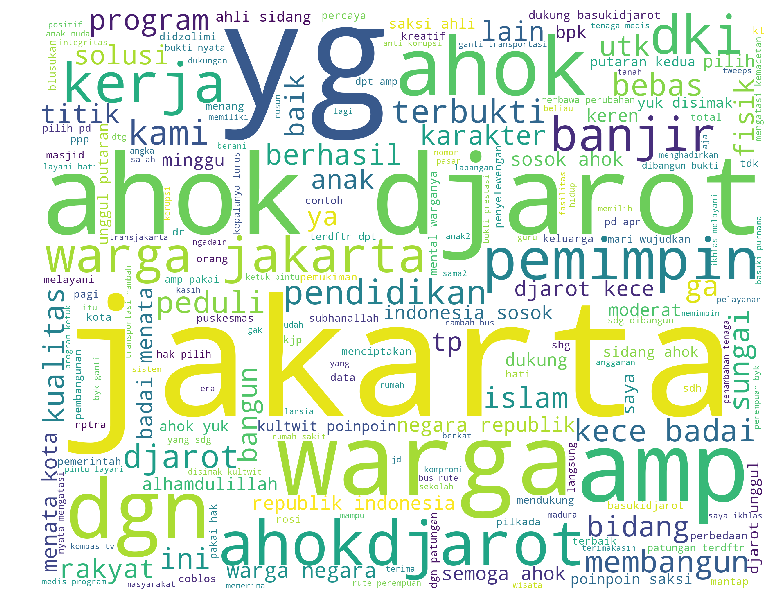

In [22]:
buat_wordcloud(positif.isi, 'white')

### Word Cloud Sentimen Netral

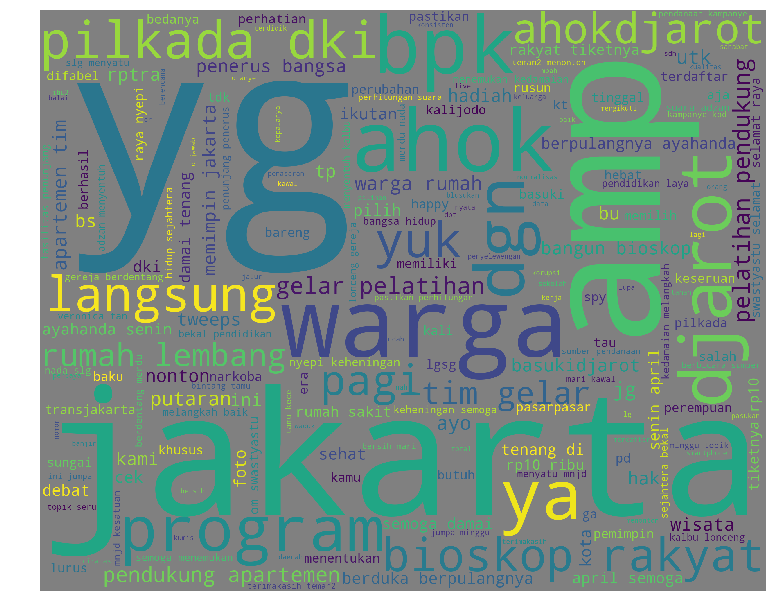

In [23]:
buat_wordcloud(netral.isi, 'grey')

### Word Cloud Sentimen Negatif

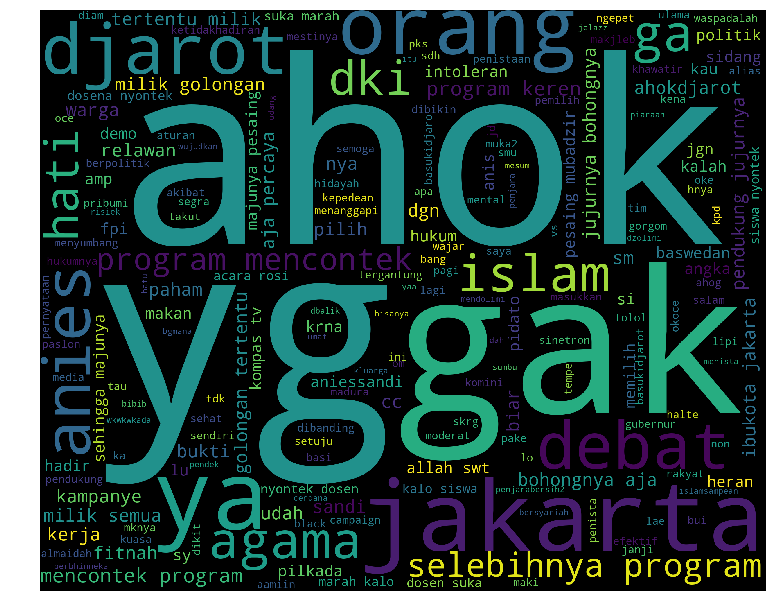

In [24]:
buat_wordcloud(negatif.isi)

## 2 - Feature Extraction

In [0]:
(train, test) = train_test_split(data, test_size = 0.1)

In [0]:
token = []

for i, row in train.iterrows():
  split = row.isi.split()
  token.append((split, row.sentimen))

In [0]:
def get_words(token):
    kalimat = []
    for (words, sentimen) in token:
        kalimat.extend(words)
    return kalimat

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [0]:
w_features = get_word_features(get_words(token))

In [29]:
w_features

dict_keys(['terimakasih', 'teman2', 'menonton', 'ini', 'jumpa', 'minggu', 'topik', 'seru', 'amp', 'bintang', 'tamu', 'kece', 'strategi', 'memberantas', 'narkoba', 'pemberdayaan', 'komunitas', 'warga', 'penegakan', 'hukum', 'yg', 'konsisten', 'rehabilitasi', '8', 'orang', 'miskin', 'kaya', 'patungan', 'menyumbang', 'penanganan', 'banjir', 'terukur', 'dgn', 'penambahan', 'daerah', 'tampungan', 'resapan', 'waduk', 'normalisasi', 'sungai', 'kawasan', 'penjaringan', 'memeluk', 'erat', 'djarot', 'salah', 'bukti', 'kedekatan', 'pemerintah', 'dengan', 'dibantaran', 'kt', 'pindah', 'rusun', 'spy', 'kualitas', 'hidupnya', 'membaik', 'percaya', 'tp', 'g', 'korupsi', 'panggung', 'konser', 'tunggal', 'cc', 'ketum', 'ppp', 'djan', 'faridz', 'bergerak', 'menangkan', 'kalo', 'saranpartai', 'kabah', 'gambarnyamendukung', 'penista', 'alquran', 'nya', 'ganti', 'babi', 'keren', 'lurah', 'estate', 'manger', 'ide', 'brilian', 'ahok', 'langsung', 'menghadiri', 'silaturahmi', 'rapat', 'koordinasi', 'nasional'

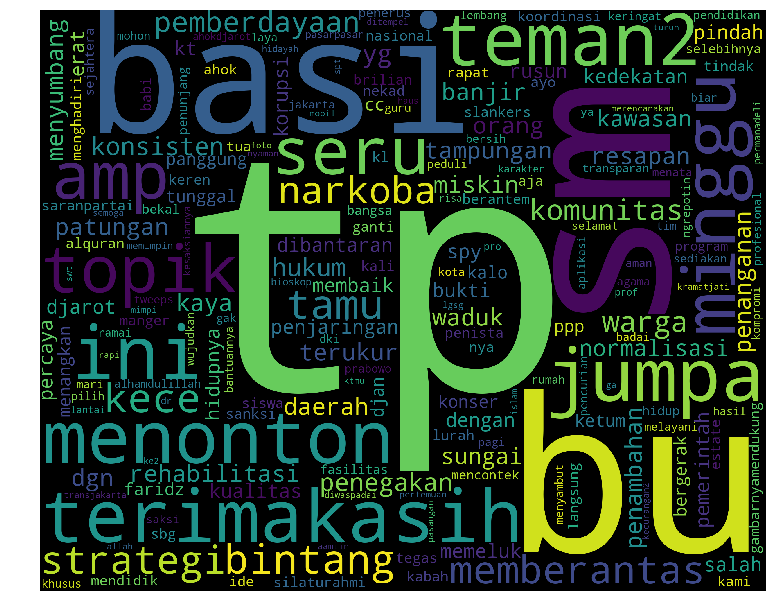

In [30]:
buat_wordcloud(w_features)

## 3 - Model Development

### NaiveBayes

In [0]:
train_set = nltk.classify.apply_features(extract_features, token)
naivebayes = nltk.classify.NaiveBayesClassifier.train(train_set)

### LSTM

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['isi'].values)
X = tokenizer.texts_to_sequences(data['isi'].values)
X = pad_sequences(X)

In [33]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

W0818 23:32:29.154046 139688910821248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 23:32:29.201376 139688910821248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 23:32:29.208343 139688910821248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 23:32:29.232556 139688910821248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0818 23:32:29.244945 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________


In [34]:
Y = pd.get_dummies(data['sentimen']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(455, 20) (455, 3)
(195, 20) (195, 3)


In [35]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 30, batch_size=batch_size, verbose = 2)

W0818 23:32:30.010283 139688910821248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
 - 5s - loss: 1.0812 - acc: 0.4264
Epoch 2/30
 - 1s - loss: 1.0502 - acc: 0.4396
Epoch 3/30
 - 1s - loss: 0.9801 - acc: 0.4879
Epoch 4/30
 - 1s - loss: 0.8102 - acc: 0.6088
Epoch 5/30
 - 1s - loss: 0.5644 - acc: 0.8088
Epoch 6/30
 - 1s - loss: 0.4241 - acc: 0.8725
Epoch 7/30
 - 1s - loss: 0.3184 - acc: 0.8901
Epoch 8/30
 - 1s - loss: 0.2563 - acc: 0.9121
Epoch 9/30
 - 1s - loss: 0.2017 - acc: 0.9253
Epoch 10/30
 - 1s - loss: 0.1559 - acc: 0.9363
Epoch 11/30
 - 1s - loss: 0.1587 - acc: 0.9187
Epoch 12/30
 - 1s - loss: 0.1597 - acc: 0.9341
Epoch 13/30
 - 1s - loss: 0.1573 - acc: 0.9429
Epoch 14/30
 - 1s - loss: 0.1348 - acc: 0.9429
Epoch 15/30
 - 1s - loss: 0.1201 - acc: 0.9538
Epoch 16/30
 - 1s - loss: 0.1138 - acc: 0.9385
Epoch 17/30
 - 1s - loss: 0.1140 - acc: 0.9495
Epoch 18/30
 - 1s - loss: 0.1129 - acc: 0.9407
Epoch 19/30
 - 1s - loss: 0.1050 - acc: 0.9582
Epoch 20/30
 - 1s - loss: 0.0954 - acc: 0.9560
Epoch 21/30
 - 1s - loss: 0.1126 - acc: 0.9495
Epoch 22/30
 - 1s - lo

## 4 - Evaluasi

### NaiveBayes

In [0]:
test_neg = test[test['sentimen'] == 'negatif'].isi
test_pos = test[test['sentimen'] == 'positif'].isi
test_net = test[test['sentimen'] == 'netral'].isi

In [37]:
net = 0
neg = 0
pos = 0

for t in test_neg: 
    res =  naivebayes.classify(extract_features(t.split()))
    if(res == 'negatif'): 
        neg += 1

for t in test_pos: 
    res =  naivebayes.classify(extract_features(t.split()))
    if(res == 'positif'): 
        pos += 1

for t in test_net: 
    res =  naivebayes.classify(extract_features(t.split()))
    if(res == 'netral'): 
        net += 1

neg_percent = (neg/len(test_neg)) *100
net_percent = (net/len(test_net)) *100
pos_percent = (pos/len(test_pos)) *100

print('[Negatif]: %s/%s ' % (len(test_neg), neg))
print('Accuracy : ' + str(neg_percent//1) + ' %')
print()    
print('[Positif]: %s/%s '  % (len(test_pos), pos))
print('Accuracy : ' + str(pos_percent//1) + ' %')
print()
print('[Netral]: %s/%s '  % (len(test_net), net))
print('Accuracy : ' + str(net_percent//1) + ' %')

[Negatif]: 18/7 
Accuracy : 38.0 %

[Positif]: 31/24 
Accuracy : 77.0 %

[Netral]: 16/10 
Accuracy : 62.0 %


### LSTM

In [0]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [39]:
pos_cnt, neg_cnt, net_cnt, pos_correct, neg_correct, net_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_validate[x]) == 1:
            pos_correct += 1
        else:
            net_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_validate[x]) == 1:
        pos_cnt += 1
    else:
        net_cnt += 1


print("Positive Accuracy", pos_correct/pos_cnt*100, "%")
print("Negative Accuracy", neg_correct/neg_cnt*100, "%")
print("Neutral Accuracy", net_correct/net_cnt*100, "%")

Positive Accuracy 68.0 %
Negative Accuracy 44.44444444444444 %
Neutral Accuracy 69.23076923076923 %


## 5 Referensi

https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis

https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras